### **ICU Patient Outcomes – Data Preparation**

---

**Overview**

This notebook continues the data science workflow for the **ICU Patient Outcomes** project by transitioning from exploratory analysis to data preparation. The focus here is on selecting, cleaning, and transforming data from the **MIMIC-IV Clinical Database Demo** to create a well-structured dataset ready for modeling and hypothesis testing.

The goal of the data preparation phase is to refine the raw hospital and ICU data into a unified analytic dataset containing relevant patient demographics, comorbidities, and clinical outcomes. This involves selecting relevant variables, addressing missingness and inconsistencies, and preparing features for subsequent modeling.

---

**Context**

- **Data source:** MIMIC-IV Clinical Database Demo (Beth Israel Deaconess Medical Center, curated by MIT LCP).  
- **Modules used:** `hosp` (hospital-wide events) and `icu` (ICU-specific stays and monitoring).  
- **Scope:** Select relevant data elements, clean and transform variables, and prepare analytic dataset for modeling.  
- **Outputs:** Refined and merged dataset containing cleaned, feature-ready variables for model development.

---

**Purpose**

- Identify and retain variables essential for patient outcome modeling.  
- Remove redundant, irrelevant, or high-risk identifiers.  
- Standardize data types, handle missing values, and encode categorical variables as needed.  
- Establish the foundation for modeling.

---

### **Step 0: Import Modules**

The initial code block imports all Python libraries used for this notebook. These include data manipulation, numerical analysis, visualization, and system utilities for a clean, reproducible workflow.

In [1]:
# Core libraries
import pandas as pd
import numpy as np

# Display and visualization
import matplotlib.pyplot as plt
import seaborn as sns

# System / file handling
import os, sys, platform, re, glob
from pathlib import Path
import warnings

# Clean notebook display
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
warnings.filterwarnings('ignore')

### **Step 1: Load data**

> **Step 1.1:**
> - The ensuing code block defines a helper function `load_all_csv_files()` to streamline reading multiple CSV files from a directory.
> - The function handles both flat and nested `.csv` folder structures
> - **Process summary:**
>   - Iterate through every file/folder in a target directory
>   - Read valid CSVs into DataFrames
>   - Return a dictionary `{table_name → DataFrame}`
>   - Print table names and shapes for confirmation

In [2]:
def load_all_csv_files(folder: Path):
    data = {}
    for p in folder.glob("*.csv"):
        if p.is_file():
            # Case 1: plain CSV file
            name = p.stem
            df = pd.read_csv(p, low_memory=False)
            data[name] = df
            print(f"Loaded {name}: {df.shape}")
        elif p.is_dir():
            # Case 2: directory named *.csv
            same_named = p / p.name
            if same_named.exists() and same_named.is_file():
                name = p.stem
                df = pd.read_csv(same_named, low_memory=False)
                data[name] = df
                print(f"Loaded (dir->file) {name}: {df.shape}")
            else:
                # Fallback: pick the first CSV inside the folder
                candidates = sorted(p.glob("*.csv"))
                if candidates:
                    name = p.stem
                    df = pd.read_csv(candidates[0], low_memory=False)
                    data[name] = df
                    print(f"Loaded (dir->first) {name}: {df.shape}")
                else:
                    print(f"⚠️ No CSV file found inside directory: {p}")
    return data

> **Step 1.2:**
> - The next code block loads all CSV files from the **`hosp`** module. This module contains hospital-wide data such as admissions, diagnoses, procedures, labs, and pharmacy events.
> - **Process summary:**
>   - Use `Path("../data/hosp")` to locate the directory
>   - Call `load_all_csv_files()` to read and store each file 
>   - Print shapes for quick verification

In [3]:
hosp_dir = Path("../data/hosp")
hosp_data = load_all_csv_files(hosp_dir)

Loaded (dir->file) admissions: (275, 16)
Loaded (dir->file) diagnoses_icd: (4506, 5)
Loaded (dir->file) drgcodes: (454, 7)
Loaded (dir->file) d_hcpcs: (89200, 4)
Loaded (dir->file) d_icd_diagnoses: (109775, 3)
Loaded (dir->file) d_icd_procedures: (85257, 3)
Loaded (dir->file) d_labitems: (1622, 4)
Loaded (dir->file) emar: (35835, 12)
Loaded (dir->file) hcpcsevent: (61, 6)
Loaded (dir->file) labevents: (107727, 16)
Loaded (dir->file) microbiologyevents: (2899, 25)
Loaded (dir->file) omr: (2964, 5)
Loaded (dir->file) patients: (100, 6)
Loaded (dir->file) pharmacy: (15306, 27)
Loaded (dir->file) poe: (45154, 12)
Loaded (dir->file) poe_detail: (3795, 5)
Loaded (dir->file) prescriptions: (18087, 21)
Loaded (dir->file) procedures_icd: (722, 6)
Loaded (dir->file) provider: (40508, 1)
Loaded (dir->file) services: (319, 5)
Loaded (dir->file) transfers: (1190, 7)


> **Step 1.3:**
> - The final code block in this section loads all CSV files from the **`icu`** module, which includes ICU-specific data such as stays, chart events, and caregiver details.
> - **Process summary:**
>   - Use `Path("../data/icu")` to locate the directory
>   - Call `load_all_csv_files()` to read and store each file
>   - Print shapes for quick verification

In [4]:
icu_dir = Path("../data/icu")
icu_data = load_all_csv_files(icu_dir)

Loaded (dir->file) caregiver: (15468, 1)
Loaded (dir->file) chartevents: (668862, 11)
Loaded (dir->file) datetimeevents: (15280, 10)
Loaded (dir->file) icustays: (140, 8)
Loaded (dir->file) ingredientevents: (25728, 17)
Loaded (dir->file) inputevents: (20404, 26)
Loaded (dir->file) outputevents: (9362, 9)
Loaded (dir->file) procedureevents: (1468, 22)


### **Step 2: Select and clean data**

---

**Overview**

This step initiates the **data selection and cleaning phase**, focusing on identifying, profiling, and refining the key hospital and ICU tables required for modeling. The process ensures that only clinically and operationally relevant variables are retained while maintaining consistency across data types and structures.

**Purpose**

- Inspect the structure and content of each selected `hosp` and `icu` table  
- Select and document the specific columns retained or excluded
- Compute baseline summaries and assess data quality before transformation
- Establish clean, consistent input tables for subsequent feature engineering and integration

> **Step 2.1:**
> - The ensuing code block defines a helper function `inspect_tables()` that will be used to review all desired `hosp` and `icu` tables.
> - This function loops through each selected DataFrame, printing basic information and returning a combined column inventory.
> - **Process summary:**
>   - Iterate through each table in a provided dictionary  
>   - Display its shape, column names, and data types  
>   - (Optional) include non-null counts and sample rows for quick review  
>   - Combine results into a single tidy inventory DataFrame

In [5]:
def inspect_tables(
    tables: dict[str, pd.DataFrame],
    *,
    show_non_null: bool = False,
    sample_rows: int | None = None,
    export_path: str | None = None
) -> pd.DataFrame:
    """
    Inspect a dict of DataFrames and return a tidy inventory:
      ['table', 'column', 'dtype', ('non_null' if requested)]
    Also prints per-table shape and schema preview.
    """
    frames = []
    for name in sorted(tables.keys()):
        df = tables[name]
        n_rows, n_cols = df.shape
        print(f"\n===== {name} =====")
        print(f"Shape: {n_rows:,} rows × {n_cols:,} columns")

        schema = pd.DataFrame({
            "column": df.columns,
            "dtype": df.dtypes.astype(str).values
        })
        if show_non_null:
            schema["non_null"] = df.notna().sum().values

        display(schema)

        if sample_rows:
            display(df.head(sample_rows))

        schema["table"] = name
        col_order = ["table", "column", "dtype"] + (["non_null"] if show_non_null else [])
        frames.append(schema[col_order])

    inventory = pd.concat(frames, ignore_index=True)

    if export_path:
        inventory.to_csv(export_path, index=False)
        print(f"\nInventory written to: {export_path}")

    return inventory

> **Step 2.2a:**
> - This step reviews the structure and metadata of all selected tables from the `hosp` module to confirm their suitability for analysis
> - **Process summary:**
>   - Define a subset of relevant hospital-wide tables: `admissions`, `patients`, `transfers`, `diagnoses_icd`, and `d_icd_diagnoses`
>   - Filter the full `hosp_data` dictionary to include only these tables 
>   - Call the `inspect_tables()` helper function to display each table’s shape, schema, and data types
>   - Use the output to verify that the retained columns align with the data selection criteria before proceeding to cleaning

In [6]:
selected_hosp_tables = [
    "admissions",
    "patients",
    "transfers",
    "diagnoses_icd",
    "d_icd_diagnoses",
]

# Filter to only include the relevant tables
filtered_hosp_data = {k: v for k, v in hosp_data.items() if k in selected_hosp_tables}

# Run inspection on the filtered subset
hosp_inventory = inspect_tables(
    filtered_hosp_data,
    show_non_null=False,
    sample_rows=None,
    export_path=None
)


===== admissions =====
Shape: 275 rows × 16 columns


,column,dtype
0,subject_id,int64
1,hadm_id,int64
2,admittime,object
3,dischtime,object
4,deathtime,object
5,admission_type,object
6,admit_provider_id,object
7,admission_location,object
8,discharge_location,object
9,insurance,object



===== d_icd_diagnoses =====
Shape: 109,775 rows × 3 columns


,column,dtype
0,icd_code,object
1,icd_version,int64
2,long_title,object



===== diagnoses_icd =====
Shape: 4,506 rows × 5 columns


,column,dtype
0,subject_id,int64
1,hadm_id,int64
2,seq_num,int64
3,icd_code,object
4,icd_version,int64



===== patients =====
Shape: 100 rows × 6 columns


,column,dtype
0,subject_id,int64
1,gender,object
2,anchor_age,int64
3,anchor_year,int64
4,anchor_year_group,object
5,dod,object



===== transfers =====
Shape: 1,190 rows × 7 columns


,column,dtype
0,subject_id,int64
1,hadm_id,float64
2,transfer_id,int64
3,eventtype,object
4,careunit,object
5,intime,object
6,outtime,object


> **Step 2.2b:**
> - This step reviews the structure and metadata of all selected tables from the `icu` module to confirm their suitability for analysis
> - **Process summary:**
>   - Define a subset of relevant icu-level tables: `icu_stays`
>   - Filter the full `icu_data` dictionary to include only these tables
>   - Call the `inspect_tables()` helper function to display each table’s shape, schema, and data types
>   - Use the output to verify that the retained columns align with the data selection criteria before proceeding to cleaning

In [7]:
selected_icu_tables = {"icustays": icu_data["icustays"]}

# Inspect the table
icu_inventory = inspect_tables(
    selected_icu_tables,
    show_non_null=False,
    sample_rows=None,
    export_path=None
)


===== icustays =====
Shape: 140 rows × 8 columns


,column,dtype
0,subject_id,int64
1,hadm_id,int64
2,stay_id,int64
3,first_careunit,object
4,last_careunit,object
5,intime,object
6,outtime,object
7,los,float64


> **Step 2.3:**
> - The following blocks apply a **consistent, table-by-table cleaning workflow** across all selected datasets from the `hosp` and `icu` modules. This ensures that each table is validated, standardized, and ready for feature engineering and integration
> - Each table undergoes the following substeps:
>   - **Step 2.3.1** - Column selection – retain only relevant variables
>   - **Step 2.3.2** - Baseline summaries – generate descriptive statistics and data type profiles
>   - **Step 2.3.3** - Missing value assessment and treatment – quantify, impute, or flag missing values
>   - **Step 2.3.4** - Duplicate assessment and removal – identify and resolve redundant records
>   - **Step 2.3.5** - Outlier identification and treatment – detect extreme numeric values using IQR-based rules
>   - **Step 2.3.6** - Categorical standardization – normalize text formatting and category labels
>   - **Step 2.3.7** - Post-cleaning verification – re-evaluate summary statistics and data integrity
>   - **Step 2.3.8** - Finalization and saving – save the cleaned DataFrame for subsequent feature engineering

In [8]:
# --- Step 2.3.1: Column selection (admissions) ---

# Define columns to retain
keep_cols = [
    "subject_id", "hadm_id", "admittime", "dischtime", "deathtime",
    "admission_type", "admission_location", "discharge_location",
    "insurance", "language", "marital_status", "race",
    "hospital_expire_flag"
]

# Retrieve the admissions table from the hosp_data dictionary
admissions = hosp_data["admissions"]

# Retain only selected columns
admissions_clean = admissions[keep_cols].copy()

# Print summary
print(f"Retained {len(keep_cols)} columns. Shape: {admissions_clean.shape}")
admissions_clean.info()

Retained 13 columns. Shape: (275, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275 entries, 0 to 274
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   subject_id            275 non-null    int64 
 1   hadm_id               275 non-null    int64 
 2   admittime             275 non-null    object
 3   dischtime             275 non-null    object
 4   deathtime             15 non-null     object
 5   admission_type        275 non-null    object
 6   admission_location    275 non-null    object
 7   discharge_location    233 non-null    object
 8   insurance             275 non-null    object
 9   language              275 non-null    object
 10  marital_status        263 non-null    object
 11  race                  275 non-null    object
 12  hospital_expire_flag  275 non-null    int64 
dtypes: int64(3), object(10)
memory usage: 28.1+ KB


In [9]:
# --- Step 2.3.2: Baseline summaries (admissions) ---

df = admissions_clean.copy()

# Create column groups
id_cols = ["subject_id", "hadm_id"]
cat_cols = ["admission_type", "admission_location", "discharge_location", "insurance", "language", "marital_status", "race", "hospital_expire_flag"]
datetime_cols = ["admittime", "dischtime", "deathtime"]
for c in datetime_cols:
    df[c] = pd.to_datetime(df[c], errors="coerce")

# Summaries
print("\nIdentifier summary:")
display(df[id_cols].agg(["nunique"]).T)

print("\nCategorical summary:")
display(df[cat_cols].agg(["nunique"]).T)

print("\nDatetime summary:")
display(df[datetime_cols].agg(["nunique"]).T)


Identifier summary:


,nunique
subject_id,100
hadm_id,275



Categorical summary:


,nunique
admission_type,9
admission_location,10
discharge_location,10
insurance,3
language,2
marital_status,4
race,14
hospital_expire_flag,2



Datetime summary:


,nunique
admittime,275
dischtime,275
deathtime,15


In [10]:
# --- Step 2.3.3a: Missing values assessment (admissions) ---

# Count missing values
missing = df.isna().sum().to_frame("missing")
missing["pct_missing"] = (missing["missing"] / len(df) * 100).round(2)

print("Missing value summary:")
display(missing[missing["missing"] > 0].sort_values("pct_missing", ascending=False))

Missing value summary:


,missing,pct_missing
deathtime,260,94.55
discharge_location,42,15.27
marital_status,12,4.36


In [11]:
# --- Step 2.3.3b: Missing values imputation (admissions) ---

# Fill missing values based on context
df["deathtime"] = df["deathtime"].fillna("NaT")
df["discharge_location"] = df["discharge_location"].fillna("UNKNOWN")
df["marital_status"] = df["marital_status"].fillna("UNKNOWN")

# Verify fixes
missing_after = df.isna().sum().to_frame("missing")
missing_after["pct_missing"] = (missing_after["missing"] / len(df) * 100).round(2)
display(missing_after[missing_after["missing"] > 0])

,missing,pct_missing
deathtime,260,94.55


In [12]:
# --- Step 2.3.4: Duplicate assessment and treatment (admissions) ---

# Check for full-row duplicates
duplicate_rows = df.duplicated().sum()
print(f"Duplicate full rows: {duplicate_rows}")

# Check for duplicate unique identifiers
dup_hadm = df["hadm_id"].duplicated().sum()
print(f"Duplicate hadm_id values: {dup_hadm}")

# If duplicates exist, keep the first and remove extras
if duplicate_rows > 0 or dup_hadm > 0:
    df = df.drop_duplicates(subset="hadm_id", keep="first")
    print("Duplicates removed.")
else:
    print("No duplicates detected.")

Duplicate full rows: 0
Duplicate hadm_id values: 0
No duplicates detected.


In [13]:
# --- Step 2.3.5: Outlier assessment (admissions) ---

# The admissions table contains no continuous numeric fields suitable for outlier detection.
# All remaining variables are identifers, categorical, or datetime and not subject to statistical outlier checks.
print("No numeric or continuous fields present in the admissions table. Outlier assessment not applicable.")

No numeric or continuous fields present in the admissions table. Outlier assessment not applicable.


In [14]:
# --- Step 2.3.6: Categorical handling (admissions) ---

# Identify categorical columns
cat_cols = ["admission_type", "admission_location", "discharge_location",
            "insurance", "language", "marital_status", "race"]

# Standardize text formatting
for c in cat_cols:
    df[c] = df[c].astype(str).str.strip().str.replace(r"\s+", " ", regex=True)
    df[c] = df[c].apply(lambda x: "UNKNOWN" if x.upper() == "UNKNOWN" else x.title())

In [15]:
# --- Step 2.3.7: Post-cleaning statistics (admissions) ---

# Re-check categorical (text only) and datetime summaries
text_cat_cols = ["admission_type", "admission_location", "discharge_location",
                 "insurance", "language", "marital_status", "race"]
datetime_cols = ["admittime", "dischtime", "deathtime"]

print("\nCategorical summary (post-cleaning):")
display(df[text_cat_cols].agg(["nunique"]).T)

print("\n'hospital_expire_flag' distribution:")
display(df["hospital_expire_flag"].value_counts(dropna=False).to_frame("count"))

print("\nDatetime summary (post-cleaning):")
display(df[datetime_cols].agg(["nunique"]).T)


Categorical summary (post-cleaning):


,nunique
admission_type,9
admission_location,10
discharge_location,11
insurance,3
language,2
marital_status,5
race,14



'hospital_expire_flag' distribution:


,count
hospital_expire_flag,
0,260
1,15



Datetime summary (post-cleaning):


,nunique
admittime,275
dischtime,275
deathtime,15


In [16]:
# --- Step 2.3.8: Finalize cleaned table (admissions) ---

df_admissions = df.copy()
print(f"✅ Cleaned admissions table saved as 'df_admissions' with shape: {df_admissions.shape}")

✅ Cleaned admissions table saved as 'df_admissions' with shape: (275, 13)


---

#### **Summary of `admissions` table cleaning**

**Key Actions Performed:**
| Category | Description |
|-----------|--------------|
| **Columns retained** | `subject_id`, `hadm_id`, `admittime`, `dischtime`, `deathtime`, `admission_type`, `admission_location`, `discharge_location`, `insurance`, `race`, `hospital_expire_flag` |
| **Columns removed** | `admit_provider_id`, `edregtime`, `edouttime` |
| **Columns optionally retained** | `language`, `marital_status` (contextual demographic fields retained for completeness) |
| **Missing data handling** | `discharge_location` and `marital_status` imputed with `"UNKNOWN"`; `deathtime` intentionally left as NaT for surviving patients |
| **Duplicates** | Verified by `hadm_id`; no duplicates detected |
| **Outliers** | No continuous numeric columns available for outlier assessment; all categorical and binary fields verified for validity |
| **Categorical handling** | Trimmed whitespace, standardized capitalization, and preserved "UNKNOWN" in uppercase; hospital_expire_flag retained as numeric binary (0/1) |
| **Final shape** | 275 rows × 13 columns |

In [17]:
# --- Step 2.3.1: Column selection (d_icd_diagnoses) ---

# Define columns to retain
keep_cols = ["icd_code", "icd_version", "long_title"]

# Retrieve the d_icd_diagnoses table from the hosp_data dictionary
d_icd_diagnoses = hosp_data["d_icd_diagnoses"]

# Retain only selected columns
d_icd_diagnoses_clean = d_icd_diagnoses[keep_cols].copy()

# Print summary
print(f"Retained {len(keep_cols)} columns. Shape: {d_icd_diagnoses_clean.shape}")
d_icd_diagnoses_clean.info()

Retained 3 columns. Shape: (109775, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109775 entries, 0 to 109774
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   icd_code     109775 non-null  object
 1   icd_version  109775 non-null  int64 
 2   long_title   109775 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.5+ MB


In [18]:
# --- Step 2.3.2: Baseline summaries (d_icd_diagnoses) ---

df = d_icd_diagnoses_clean.copy()

# Create column groups
id_cols = ["icd_code"]
cat_cols = ["icd_version", "long_title"]

# Summaries
print("\nIdentifier summary:")
display(df[id_cols].agg(["nunique"]).T)

print("\nCategorical summary:")
display(df[cat_cols].agg(["nunique"]).T)


Identifier summary:


,nunique
icd_code,109282



Categorical summary:


,nunique
icd_version,2
long_title,106327


In [19]:
# --- Step 2.3.3: Missing values (d_icd_diagnoses) ---

# Count missing values
missing = df.isna().sum().to_frame("missing")
missing["pct_missing"] = (missing["missing"] / len(df) * 100).round(2)

print("Missing value summary:")
display(missing[missing["missing"] > 0].sort_values("pct_missing", ascending=False))

Missing value summary:


,missing,pct_missing


In [20]:
# --- Step 2.3.4: Duplicate assessment and treatment (d_icd_diagnoses) ---

# Check for full-row duplicates
duplicate_rows = df.duplicated().sum()
print(f"Duplicate full rows: {duplicate_rows}")

# Check for duplicate unique identifiers
dup_icd = df["icd_code"].duplicated().sum()
print(f"Duplicate icd_code values: {dup_icd}")

# If duplicates exist, keep the first and remove extras
if dup_icd > 0:
    df = df.drop_duplicates(subset="icd_code", keep="first")
    print("Duplicates removed.")
else:
    print("No duplicates detected.")

Duplicate full rows: 0
Duplicate icd_code values: 493
Duplicates removed.


In [21]:
# --- Step 2.3.5: Outlier assessment (d_icd_diagnoses) ---

# The d_icd_diagnoses table contains no continuous numeric fields suitable for outlier detection.
# All remaining variables are identifiers or categorical and not subject to statistical outlier checks.
print("No numeric or continuous fields present in the d_icd_diagnoses table. Outlier assessment not applicable.")

No numeric or continuous fields present in the d_icd_diagnoses table. Outlier assessment not applicable.


In [22]:
# --- Step 2.3.6: Categorical handling (d_icd_diagnoses) ---

# Identify categorical columns
cat_cols = ["icd_version", "long_title"]

# Standardize text formatting
df["icd_code"] = df["icd_code"].astype(str).str.strip().str.upper()
df["long_title"] = df["long_title"].astype(str).str.strip().str.capitalize()

In [23]:
# --- Step 2.3.7: Post-cleaning statistics (d_icd_diagnoses) ---

# Re-check identifier and categorical summaries
id_cols = ["icd_code"]
cat_cols = ["icd_version", "long_title"]

print("\nIdentifier summary (post-cleaning):")
display(df[id_cols].agg(["nunique"]).T)

print("\nCategorical summary (post-cleaning):")
display(df[cat_cols].agg(["nunique"]).T)


Identifier summary (post-cleaning):


,nunique
icd_code,109282



Categorical summary (post-cleaning):


,nunique
icd_version,2
long_title,105834


In [24]:
# --- Step 2.3.8: Finalize cleaned table (d_icd_diagnoses) ---

df_d_icd_diagnoses = df.copy()
print(f"✅ Cleaned d_icd_diagnoses table saved as 'df_d_icd_diagnoses' with shape: {df_d_icd_diagnoses.shape}")

✅ Cleaned d_icd_diagnoses table saved as 'df_d_icd_diagnoses' with shape: (109282, 3)


#### **Summary of `d_icd_diagnoses` table cleaning**

| **Category** | **Description** |
|---------------|----------------|
| **Columns retained** | `icd_code`, `icd_version`, `long_title` |
| **Missing data handling** | No missing values detected; completeness verified across all fields |
| **Duplicates** | 493 duplicate icd_code entries detected and removed; one retained per unique code |
| **Outliers** | No continuous numeric columns available for outlier assessment; all categorical and binary fields verified for validity |
| **Categorical handling** | `icd_code` standardized to uppercase; `long_title` trimmed and capitalized |
| **Final shape** | 109,282 rows × 3 columns |

In [25]:
# --- Step 2.3.1: Column selection (diagnoses_icd) ---

# Define columns to retain
keep_cols = ["subject_id", "hadm_id", "seq_num", "icd_code", "icd_version"]

# Retrieve the diagnoses_icd table from the hosp_data dictionary
diagnoses_icd = hosp_data["diagnoses_icd"]

# Retain only selected columns
diagnoses_icd_clean = diagnoses_icd[keep_cols].copy()

# Print summary
print(f"Retained {len(keep_cols)} columns. Shape: {diagnoses_icd_clean.shape}")
diagnoses_icd_clean.info()

Retained 5 columns. Shape: (4506, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4506 entries, 0 to 4505
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   subject_id   4506 non-null   int64 
 1   hadm_id      4506 non-null   int64 
 2   seq_num      4506 non-null   int64 
 3   icd_code     4506 non-null   object
 4   icd_version  4506 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 176.1+ KB


In [26]:
# --- Step 2.3.2: Baseline summaries (diagnoses_icd) ---

df = diagnoses_icd_clean.copy()

# Create column groups
id_cols = ["subject_id", "hadm_id"]
cat_cols = ["seq_num", "icd_code", "icd_version"]

# Summaries
print("\nIdentifier summary:")
display(df[id_cols].agg(["nunique"]).T)

print("\nCategorical summary:")
display(df[cat_cols].agg(["nunique"]).T)


Identifier summary:


,nunique
subject_id,100
hadm_id,275



Categorical summary:


,nunique
seq_num,39
icd_code,1470
icd_version,2


In [27]:
# --- Step 2.3.3: Missing values (diagnoses_icd) ---

missing = df.isna().sum().to_frame("missing")
missing["pct_missing"] = (missing["missing"] / len(df) * 100).round(2)

print("Missing value summary:")
display(missing[missing["missing"] > 0].sort_values("pct_missing", ascending=False))

Missing value summary:


,missing,pct_missing


In [28]:
# --- Step 2.3.4: Duplicate assessment and treatment (diagnoses_icd) ---

# Check for full-row duplicates
duplicate_rows = df.duplicated().sum()
print(f"Duplicate full rows: {duplicate_rows}")

# Check for duplicate diagnosis entries within the same admission
dup_diag = df.duplicated(subset=["subject_id", "hadm_id", "icd_code", "icd_version"]).sum()
print(f"Duplicate diagnosis entries (same subject/admission/code): {dup_diag}")

# If duplicates exist, remove them
if dup_diag > 0 or duplicate_rows > 0:
    df = df.drop_duplicates(subset=["subject_id", "hadm_id", "icd_code", "icd_version"], keep="first")
    print("Duplicates removed.")
else:
    print("No duplicates detected.")

Duplicate full rows: 0
Duplicate diagnosis entries (same subject/admission/code): 0
No duplicates detected.


In [29]:
# --- Step 2.3.5: Outlier assessment (diagnoses_icd) ---

# The diagnoses_icd table contains no continuous numeric fields suitable for outlier detection.
# All remaining variables are identifiers or categorical and not subject to statistical outlier checks.
print("No numeric or continuous fields present in the diagnoses_icd table. Outlier assessment not applicable.")

No numeric or continuous fields present in the diagnoses_icd table. Outlier assessment not applicable.


In [30]:
# --- Step 2.3.6: Categorical handling (diagnoses_icd) ---

# Identify categorical columns
cat_cols = ["seq_num", "icd_code", "icd_version"]

# Standardize text formatting
df["icd_code"] = df["icd_code"].astype(str).str.strip().str.upper()

In [31]:
# --- Step 2.3.7: Post-cleaning statistics (diagnoses_icd) ---

# Re-check identifier and categorical summaries
id_cols = ["subject_id", "hadm_id"]
cat_cols = ["seq_num", "icd_code", "icd_version"]

print("\nIdentifier summary (post-cleaning):")
display(df[id_cols].agg(["nunique"]).T)

print("\nCategorical summary (post-cleaning):")
display(df[cat_cols].agg(["nunique"]).T)


Identifier summary (post-cleaning):


,nunique
subject_id,100
hadm_id,275



Categorical summary (post-cleaning):


,nunique
seq_num,39
icd_code,1470
icd_version,2


In [32]:
# --- Step 2.3.8: Finalize cleaned table (diagnoses_icd) ---

df_diagnoses_icd = df.copy()
print(f"✅ Cleaned diagnoses_icd table saved as 'df_diagnoses_icd' with shape: {df_diagnoses_icd.shape}")

✅ Cleaned diagnoses_icd table saved as 'df_diagnoses_icd' with shape: (4506, 5)


#### **Summary of `diagnoses_icd` table cleaning**

| **Category** | **Description** |
|---------------|----------------|
| **Columns retained** | `subject_id`, `hadm_id`, `seq_num`, `icd_code`, `icd_version` |
| **Missing data handling** | No missing values detected; all key identifiers and diagnostic codes complete |
| **Duplicates** | Checked on (`subject_id`, `hadm_id`, `icd_code`, `icd_version`); no true duplicates detected |
| **Outliers** | Not applicable - all variables categorical or ordinal |
| **Categorical handling** | `icd_code` uppercased for consistency; `icd_version` and `seq_num` retained as numeric fields treated as categorical |
| **Final shape** | 4,506 rows × 5 columns |

In [33]:
# --- Step 2.3.1: Column selection (patients) ---

# Define columns to retain
keep_cols = ["subject_id", "gender", "anchor_age", "anchor_year", "anchor_year_group", "dod"]

# Retrieve the patients table from the hosp_data dictionary
patients = hosp_data["patients"]

# Retain only selected columns
patients_clean = patients[keep_cols].copy()

# Print summary
print(f"Retained {len(keep_cols)} columns. Shape: {patients_clean.shape}")
patients_clean.info()

Retained 6 columns. Shape: (100, 6)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subject_id         100 non-null    int64 
 1   gender             100 non-null    object
 2   anchor_age         100 non-null    int64 
 3   anchor_year        100 non-null    int64 
 4   anchor_year_group  100 non-null    object
 5   dod                31 non-null     object
dtypes: int64(3), object(3)
memory usage: 4.8+ KB


In [34]:
# --- Step 2.3.2: Baseline summaries (patients) ---

df = patients_clean.copy()

# Create column groups
id_cols = ["subject_id"]
numeric_cols = ["anchor_age", "anchor_year"]
cat_cols = ["gender", "anchor_year_group"]
datetime_cols = ["dod"]
for c in datetime_cols:
    df[c] = pd.to_datetime(df[c], errors="coerce")

# Summaries
print("\nIdentifier summary:")
display(df[id_cols].agg(["nunique"]).T)

print("\nNumeric summary:")
display(df[numeric_cols].describe().T)

print("\nCategorical summary:")
display(df[cat_cols].agg(["nunique"]).T)

print("\nDatetime summary:")
display(df[datetime_cols].agg(["nunique"]).T)


Identifier summary:


,nunique
subject_id,100



Numeric summary:


,count,mean,std,min,25%,50%,75%,max
anchor_age,100.0,61.75,16.169790,21.0,51.75,63.0,72.0,91.0
anchor_year,100.0,2148.68,25.629008,2110.0,2129.00,2145.5,2172.5,2201.0



Categorical summary:


,nunique
gender,2
anchor_year_group,2



Datetime summary:


,nunique
dod,31


In [35]:
# --- Step 2.3.3a: Missing values (patients) ---

missing = df.isna().sum().to_frame("missing")
missing["pct_missing"] = (missing["missing"] / len(df) * 100).round(2)

print("Missing value summary:")
display(missing[missing["missing"] > 0].sort_values("pct_missing", ascending=False))

Missing value summary:


,missing,pct_missing
dod,69,69.0


In [36]:
# --- Step 2.3.3b: Missing values imputation (patients) ---

# Fill missing values based on context
df["dod"] = df["dod"].fillna("NaT")

In [37]:
# --- Step 2.3.4: Duplicates (patients) ---

# Check for full-row duplicates
duplicate_rows = df.duplicated().sum()
print(f"Duplicate full rows: {duplicate_rows}")

# Check for duplicate identifiers
dup_subjects = df["subject_id"].duplicated().sum()
print(f"Duplicate subject_id values: {dup_subjects}")

if dup_subjects > 0:
    df = df.drop_duplicates(subset="subject_id", keep="first")
    print("Duplicates removed.")
else:
    print("No duplicates detected.")

Duplicate full rows: 0
Duplicate subject_id values: 0
No duplicates detected.


In [38]:
# --- Step 2.3.5: Outlier assessment (patients) ---

# Check for unrealistic ages
invalid_age = df[(df["anchor_age"] < 0) | (df["anchor_age"] > 120)]
print(f"Patients with unrealistic age values: {len(invalid_age)}")

# Skip anchor_year validation (anonymized reference)
print("Note: 'anchor_year' values are anonymized and may exceed realistic calendar years. No filtering applied.")

Patients with unrealistic age values: 0
Note: 'anchor_year' values are anonymized and may exceed realistic calendar years. No filtering applied.


In [39]:
# --- Step 2.3.6: Categorical handling (patients) ---

# Identify categorical columns
cat_cols = ["gender", "anchor_year_group"]

# Standardize text formatting
df["gender"] = df["gender"].astype(str).str.strip().str.upper()
df["anchor_year_group"] = df["anchor_year_group"].astype(str).str.strip()

In [40]:
# --- Step 2.3.7: Post-cleaning statistics (patients) ---

# Re-check identifier and categorical summaries
id_cols = ["subject_id"]
numeric_cols = ["anchor_age", "anchor_year"]
cat_cols = ["gender", "anchor_year_group"]
datetime_cols = ["dod"]

print("\nIdentifier summary (post-cleaning):")
display(df[id_cols].agg(["nunique"]).T)

print("\nNumeric summary (post-cleaning):")
display(df[numeric_cols].describe().T)

print("\nCategorical summary (post-cleaning):")
display(df[cat_cols].agg(["nunique"]).T)

print("\nDatetime summary (post-cleaning):")
display(df[datetime_cols].agg(["nunique"]).T)


Identifier summary (post-cleaning):


,nunique
subject_id,100



Numeric summary (post-cleaning):


,count,mean,std,min,25%,50%,75%,max
anchor_age,100.0,61.75,16.169790,21.0,51.75,63.0,72.0,91.0
anchor_year,100.0,2148.68,25.629008,2110.0,2129.00,2145.5,2172.5,2201.0



Categorical summary (post-cleaning):


,nunique
gender,2
anchor_year_group,2



Datetime summary (post-cleaning):


,nunique
dod,31


In [41]:
# --- Step 2.3.8: Finalize cleaned table (patients) ---

df_patients = df.copy()
print(f"✅ Cleaned patients table saved as 'df_patients' with shape: {df_patients.shape}")

✅ Cleaned patients table saved as 'df_patients' with shape: (100, 6)


#### **Summary of `patients` table cleaning**

| **Category** | **Description** |
|---------------|----------------|
| **Columns retained** | `subject_id`, `gender`, `anchor_age`, `anchor_year`, `anchor_year_group`, `dod` |
| **Missing data handling** | `dod` left missing for living patients (intentional); no imputation required |
| **Duplicates** | Verified unique `subject_id` values; no duplicates detected |
| **Outliers** | Checked for unrealistic `anchor_age` (>120 yrs). `anchor_year` intentionally anonymized and may exceed realistic calendar years; retained as-is. |
| **Categorical handling** | `gender` standardized to uppercase; `anchor_year_group` trimmed |
| **Datetime handling** | `dod` parsed as datetime; nulls preserved for survivors |
| **Final shape** | 100 rows × 6 columns |

In [42]:
# --- Step 2.3.1: Column selection (transfers) ---

# Define columns to retain
keep_cols = ["subject_id", "hadm_id", "transfer_id", "eventtype", "careunit", "intime", "outtime"]

# Retrieve the transfers table from the hosp_data dictionary
transfers = hosp_data["transfers"]

# Retain only selected columns
transfers_clean = transfers[keep_cols].copy()

# Print summary
print(f"Retained {len(keep_cols)} columns. Shape: {transfers_clean.shape}")
transfers_clean.info()

Retained 7 columns. Shape: (1190, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1190 entries, 0 to 1189
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   subject_id   1190 non-null   int64  
 1   hadm_id      1136 non-null   float64
 2   transfer_id  1190 non-null   int64  
 3   eventtype    1190 non-null   object 
 4   careunit     915 non-null    object 
 5   intime       1190 non-null   object 
 6   outtime      915 non-null    object 
dtypes: float64(1), int64(2), object(4)
memory usage: 65.2+ KB


In [43]:
# --- Step 2.3.2: Baseline summaries (transfers) ---

df = transfers_clean.copy()

# Create column groups
id_cols = ["subject_id", "hadm_id", "transfer_id"]
cat_cols = ["eventtype", "careunit"]
datetime_cols = ["intime", "outtime"]
for c in datetime_cols:
    df[c] = pd.to_datetime(df[c], errors="coerce")

# Summaries
print("\nIdentifier summary:")
display(df[id_cols].agg(["nunique"]).T)

print("\nCategorical summary:")
display(df[cat_cols].agg(["nunique"]).T)

print("\nDatetime summary:")
display(df[datetime_cols].agg(["nunique"]).T)


Identifier summary:


,nunique
subject_id,100
hadm_id,275
transfer_id,1190



Categorical summary:


,nunique
eventtype,4
careunit,31



Datetime summary:


,nunique
intime,1190
outtime,915


In [44]:
# --- Step 2.3.3a: Missing values assessment (transfers) ---

# Count missing values
missing = df.isna().sum().to_frame("missing")
missing["pct_missing"] = (missing["missing"] / len(df) * 100).round(2)

print("Missing value summary:")
display(missing[missing["missing"] > 0].sort_values("pct_missing", ascending=False))

Missing value summary:


,missing,pct_missing
careunit,275,23.11
outtime,275,23.11
hadm_id,54,4.54


In [45]:
# --- Step 2.3.3b: Missing values treatment (transfers) ---

# Drop rows with missing hadm_id (non-linkable)
before = len(df)
df = df.dropna(subset=["hadm_id"])
print(f"Dropped {before - len(df)} rows missing hadm_id.")

# Impute careunit with 'UNKNOWN' for missing entries
df["careunit"] = df["careunit"].fillna("UNKNOWN")

# Leave outtime as-is (missing values indicate incomplete or final events)
df["outtime"] = df["outtime"].fillna("NaT")
missing_outtime = df["outtime"].isna().sum()
print(f"Retained {missing_outtime} rows with missing outtime (unrecorded discharge or ongoing stay).")

# Verify results
missing_after = df.isna().sum().to_frame("missing")
missing_after["pct_missing"] = (missing_after["missing"] / len(df) * 100).round(2)
display(missing_after[missing_after["missing"] > 0])

Dropped 54 rows missing hadm_id.
Retained 275 rows with missing outtime (unrecorded discharge or ongoing stay).


,missing,pct_missing
outtime,275,24.21


In [46]:
# --- Step 2.3.4: Duplicates assessment (transfers) ---

# Check for full-row duplicates
duplicate_rows = df.duplicated().sum()
print(f"Duplicate full rows: {duplicate_rows}")

# Check for duplicate identifiers
dup_transfers = df["transfer_id"].duplicated().sum()
print(f"Duplicate transfer_id values: {dup_transfers}")

if dup_transfers > 0:
    df = df.drop_duplicates(subset="transfer_id", keep="first")
    print("Duplicates removed.")
else:
    print("No duplicates detected.")

Duplicate full rows: 0
Duplicate transfer_id values: 0
No duplicates detected.


In [47]:
# --- Step 2.3.5: Outlier assessment (diagnoses_icd) ---

# The transfers table contains no continuous numeric fields suitable for outlier detection.
# All remaining variables are identifiers, categorical, or datetime and not subject to statistical outlier checks.
print("No numeric or continuous fields present in the transfers table. Outlier assessment not applicable.")

No numeric or continuous fields present in the transfers table. Outlier assessment not applicable.


In [48]:
# --- Step 2.3.6: Categorical handling (transfers) ---

# Identify categorical columns
cat_cols = ["eventtype", "careunit"]

# Standardize text formatting
for c in cat_cols:
    df[c] = df[c].astype(str).str.strip().str.upper()

In [49]:
# --- Step 2.3.7: Post-cleaning statistics (transfers) ---

# Re-check identifier, categorical, and datetime summaries
id_cols = ["subject_id", "hadm_id", "transfer_id"]
cat_cols = ["eventtype", "careunit"]
datetime_cols = ["intime", "outtime"]

print("\nIdentifier summary (post-cleaning):")
display(df[id_cols].agg(["nunique"]).T)

print("\nCategorical summary (post-cleaning):")
display(df[cat_cols].agg(["nunique"]).T)

print("\nDatetime summary (post-cleaning):")
display(df[datetime_cols].agg(["nunique"]).T)


Identifier summary (post-cleaning):


,nunique
subject_id,100
hadm_id,275
transfer_id,1136



Categorical summary (post-cleaning):


,nunique
eventtype,4
careunit,31



Datetime summary (post-cleaning):


,nunique
intime,1136
outtime,861


In [50]:
# --- Step 2.3.8: Finalize cleaned table (transfers) ---

df_transfers = df.copy()
print(f"✅ Cleaned transfers table saved as 'df_transfers' with shape: {df_transfers.shape}")

✅ Cleaned transfers table saved as 'df_transfers' with shape: (1136, 7)


#### **Summary of `transfers` table cleaning**

| **Category** | **Description** |
|---------------|----------------|
| **Columns retained** | `subject_id`, `hadm_id`, `transfer_id`, `eventtype`, `careunit`, `intime`, `outtime` |
| **Missing data handling** | Dropped 4.5% of records missing `hadm_id` (unlinked transfers); imputed missing `careunit` with `"UNKNOWN"`; retained missing `outtime` to represent incomplete or final events. |
| **Duplicates** | Checked by `transfer_id`; none detected |
| **Outliers** | Not applicable - all variables categorical or ordinal |
| **Categorical handling** | Trimmed whitespace and converted `eventtype` and `careunit` values to uppercase for consistency |
| **Final shape** | 1,136 rows × 7 columns |

In [52]:
# --- Step 2.3.1: Column selection (icustays) ---

# Define columns to retain
keep_cols = ["subject_id", "hadm_id", "stay_id", "first_careunit", "last_careunit", "intime", "outtime", "los"]

# Retrieve the icustays table from the icu_data dictionary
icustays = icu_data["icustays"]

# Retain only selected columns
icustays_clean = icustays[keep_cols].copy()

# Print summary
print(f"Retained {len(keep_cols)} columns. Shape: {icustays_clean.shape}")
icustays_clean.info()

Retained 8 columns. Shape: (140, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140 entries, 0 to 139
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   subject_id      140 non-null    int64  
 1   hadm_id         140 non-null    int64  
 2   stay_id         140 non-null    int64  
 3   first_careunit  140 non-null    object 
 4   last_careunit   140 non-null    object 
 5   intime          140 non-null    object 
 6   outtime         140 non-null    object 
 7   los             140 non-null    float64
dtypes: float64(1), int64(3), object(4)
memory usage: 8.9+ KB


In [53]:
# --- Step 2.3.2: Baseline summaries (icustays) ---

df = icustays_clean.copy()

# Create column groups
id_cols = ["subject_id", "hadm_id", "stay_id"]
numeric_cols = ["los"]
cat_cols = ["first_careunit", "last_careunit"]
datetime_cols = ["intime", "outtime"]
for c in datetime_cols:
    df[c] = pd.to_datetime(df[c], errors="coerce")

# Summaries
print("\nIdentifier summary:")
display(df[id_cols].agg(["nunique"]).T)

print("\nNumeric summary:")
display(df[numeric_cols].describe().T)

print("\nCategorical summary:")
display(df[cat_cols].agg(["nunique"]).T)

print("\nDatetime summary:")
display(df[datetime_cols].agg(["nunique"]).T)


Identifier summary:


,nunique
subject_id,100
hadm_id,128
stay_id,140



Numeric summary:


,count,mean,std,min,25%,50%,75%,max
los,140.0,3.679379,3.896354,0.023727,1.170663,2.155093,4.907749,20.528681



Categorical summary:


,nunique
first_careunit,9
last_careunit,9



Datetime summary:


,nunique
intime,140
outtime,140


In [54]:
# --- Step 2.3.3: Missing values (icustays) ---

missing = df.isna().sum().to_frame("missing")
missing["pct_missing"] = (missing["missing"] / len(df) * 100).round(2)

print("Missing value summary:")
display(missing[missing["missing"] > 0].sort_values("pct_missing", ascending=False))

Missing value summary:


,missing,pct_missing


In [55]:
# --- Step 2.3.4: Duplicates assessment (icustays) ---

# Check for full-row duplicates
duplicate_rows = df.duplicated().sum()
print(f"Duplicate full rows: {duplicate_rows}")

# Check for duplicate identifiers
dup_stay = df["stay_id"].duplicated().sum()
print(f"Duplicate stay_id values: {dup_stay}")

if dup_stay > 0:
    df = df.drop_duplicates(subset="stay_id", keep="first")
    print("Duplicates removed.")
else:
    print("No duplicates detected.")

Duplicate full rows: 0
Duplicate stay_id values: 0
No duplicates detected.


Potential LOS outliers: 10

LOS IQR range: 1.17–4.91 | Thresholds: <-4.43 or >10.51


,stay_id,hadm_id,los
9,37293400,21027282,13.899225
11,38197705,28998349,15.688924
21,30955999,21607814,13.214676
32,38383343,23559586,16.069838
47,32359580,22987108,20.528681


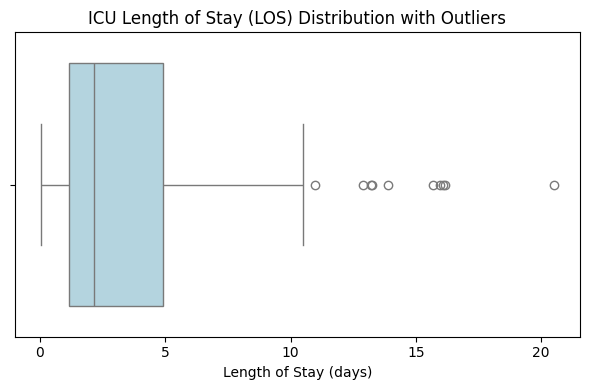

In [56]:
# --- Step 2.3.5a: Outliers assessment (icustays) ---

# Identify outliers in length of stay (LOS) using IQR
q1, q3 = df["los"].quantile([0.25, 0.75])
iqr = q3 - q1
lower = q1 - 1.5 * iqr
upper = q3 + 1.5 * iqr

# Flag potential outliers
outliers = df[(df["los"] < lower) | (df["los"] > upper)]
print(f"Potential LOS outliers: {len(outliers)}")

# Display summary statistics for context
print(f"\nLOS IQR range: {q1:.2f}–{q3:.2f} | Thresholds: <{lower:.2f} or >{upper:.2f}")
if len(outliers) > 0:
    display(outliers[["stay_id", "hadm_id", "los"]].head())
else:
    print("No extreme LOS outliers detected.")

# --- LOS Outlier Distribution ---

plt.figure(figsize=(6, 4))
sns.boxplot(x=df["los"], color="lightblue")
plt.title("ICU Length of Stay (LOS) Distribution with Outliers", fontsize=12)
plt.xlabel("Length of Stay (days)")
plt.tight_layout()
plt.show()


In [57]:
# --- Step 2.3.5b: Outliers treatment (icustays) ---

# Evaluate whether LOS outliers represent data errors or valid clinical extremes
print(f"Outliers above upper threshold (> {upper:.2f} days): {len(outliers)}")

# Decision: retain outliers
# These extended ICU stays likely reflect true clinical variability (e.g., critical or long-term patients)
# No rows removed or capped - retained for downstream modeling
print("No action taken. LOS outliers retained to preserve clinical realism in ICU stay durations.")


Outliers above upper threshold (> 10.51 days): 10
No action taken. LOS outliers retained to preserve clinical realism in ICU stay durations.


In [58]:
# --- Step 2.3.6: Categorical handling (icustays) ---

# Identify categorical columns
cat_cols = ["first_careunit", "last_careunit"]

# Standardize text formatting
for c in cat_cols:
    df[c] = df[c].astype(str).str.strip().str.title()

In [59]:
# --- Step 2.3.7: Post-cleaning statistics (transfers) ---

# Re-check identifier, numeric, categorical, and datetime summaries
id_cols = ["subject_id", "hadm_id", "stay_id"]
numeric_cols = ["los"]
cat_cols = ["first_careunit", "last_careunit"]
datetime_cols = ["intime", "outtime"]

print("\nIdentifier summary (post-cleaning):")
display(df[id_cols].agg(["nunique"]).T)

print("\nNumeric summary (post-cleaning):")
display(df[numeric_cols].describe().T)

print("\nCategorical summary (post-cleaning):")
display(df[cat_cols].agg(["nunique"]).T)

print("\nDatetime summary (post-cleaning):")
display(df[datetime_cols].agg(["nunique"]).T)


Identifier summary (post-cleaning):


,nunique
subject_id,100
hadm_id,128
stay_id,140



Numeric summary (post-cleaning):


,count,mean,std,min,25%,50%,75%,max
los,140.0,3.679379,3.896354,0.023727,1.170663,2.155093,4.907749,20.528681



Categorical summary (post-cleaning):


,nunique
first_careunit,9
last_careunit,9



Datetime summary (post-cleaning):


,nunique
intime,140
outtime,140


In [60]:
# --- Step 2.3.8: Finalize cleaned table (icustays) ---

df_icustays = df.copy()
print(f"✅ Cleaned icustays table saved as 'df_icustays' with shape: {df_icustays.shape}")

✅ Cleaned icustays table saved as 'df_icustays' with shape: (140, 8)


#### **Summary of `icustays` table cleaning**

| **Category** | **Description** |
|---------------|----------------|
| **Columns retained** | `subject_id`, `hadm_id`, `stay_id`, `first_careunit`, `last_careunit`, `intime`, `outtime`, `los` |
| **Missing data handling** | Verified completeness of ICU stay records; minimal missing timestamps retained to represent ongoing or unrecorded discharges |
| **Duplicates** | Checked by `stay_id`; no duplicates detected |
| **Outliers** | Identified 10 prolonged LOS values (>10.5 days) using IQR method; retained as clinically valid long-stay events |
| **Categorical handling** | Standardized `first_careunit` and `last_careunit` names to title case |
| **Final shape** | 140 rows × 8 columns |

### **Step 3: Feature engineering**

---

**Overview**

This step enhances the cleaned `hosp` and `icu` tables by creating new variables that capture clinically and analytically meaningful patterns not directly represented in the raw data. The engineered features aim to improve model interpretability and predictive performance by encoding temporal, demographic, and diagnostic information relevant to ICU outcomes.

**Purpose**

- Derive features that summarize key aspects of patient encounters (e.g., LOS, readmissions, ICU exposure) 
- Transform existing variables into formats more suitable for modeling
- Introduce flags and aggregations that reflect domain-specific insights about patient flow and care complexity
- Maintain alignment with the project’s modeling goal - predicting and characterizing ICU-related outcomes

In [61]:
# --- Step 3.1: Feature Engineering (admissions) ---

df = df_admissions.copy()

# Ensure datetimes
df["admittime"] = pd.to_datetime(df["admittime"], errors="coerce")
df["dischtime"] = pd.to_datetime(df["dischtime"], errors="coerce")

# 1) Hospital LOS (days)
df["hospital_los_days"] = (df["dischtime"] - df["admittime"]).dt.total_seconds() / 86400
df["hospital_los_days"] = df["hospital_los_days"].round(2)

# 2) Weekend admission flag
df["admit_dayofweek"] = df["admittime"].dt.dayofweek
df["weekend_admit_flag"] = df["admit_dayofweek"].isin([5, 6]).astype("Int64")

# 3) 30-day readmission flag (same patient → next admission)
df = df.sort_values(["subject_id", "admittime"], kind="mergesort")
df["next_admit"] = df.groupby("subject_id", dropna=False)["admittime"].shift(-1)
df["days_to_next_admit"] = (df["next_admit"] - df["dischtime"]).dt.total_seconds() / 86400
df["days_to_next_admit"] = df["days_to_next_admit"].round(1)

# Flag: next admit occurs 0–30 days after discharge
df["readmit_30d_flag"] = (
    (df["days_to_next_admit"] >= 0) & (df["days_to_next_admit"] <= 30)
).astype("Int64").fillna(0)

# Tidy up helper columns
derived_cols = ["hospital_los_days", "weekend_admit_flag", "readmit_30d_flag"]
helpers = ["admit_dayofweek", "next_admit", "days_to_next_admit"]

df_admissions_feat = df.drop(columns=helpers)

In [62]:
# --- Step 3.2: Feature Engineering (patients) ---

df = df_patients.copy()

# Robust age grouping: include anonymized high ages (>=120)
bins = [0, 18, 40, 65, 80, np.inf]
labels = ["0-17", "18-39", "40-64", "65-79", "80+"]

df["age_group"] = pd.cut(
    df["anchor_age"],
    bins=bins,
    labels=labels,
    right=False,
    include_lowest=True,
    ordered=True
)

df_patients_feat = df.copy()

In [63]:
# --- Step 3.3: Feature Engineering (transfers) ---

df = df_transfers.copy()

# ICU-related transfer flag
df["icu_transfer_flag"] = df["careunit"].str.contains("ICU", case=False, na=False).astype("Int64")

# Number of transfers per admission (per hadm_id)
df["num_transfers_per_admit"] = df.groupby("hadm_id")["transfer_id"].transform("size").astype("Int64")

df_transfers_feat = df.copy()

In [64]:
# --- Step 3.4: Feature Engineering (diagnoses_icd) ---

df = df_diagnoses_icd.copy()

# Ensure numeric ordering for sequence numbers
df["seq_num"] = pd.to_numeric(df["seq_num"], errors="coerce")

# Primary diagnosis flag: first diagnosis per admission (lowest seq_num)
df["primary_diagnosis_flag"] = (
    df.groupby("hadm_id")["seq_num"].transform("min") == df["seq_num"]
).astype("Int64")

# Diagnosis count per admission
df["num_diagnoses_per_admit"] = (
    df.groupby("hadm_id")["icd_code"].transform("size").astype("Int64")
)

df_diagnoses_icd_feat = df.copy()

In [65]:
# --- Step 3.5: Feature Engineering (icustays) ---

df = df_icustays.copy()

# ICU LOS in hours (finer temporal granularity)
df["icu_los_hours"] = (df["los"] * 24).round(1)

# Multi-unit flag: patient transferred between different ICU units
df["multiunit_flag"] = (df["first_careunit"] != df["last_careunit"]).astype("Int64")

df_icustays_feat = df.copy()

### **Step 4: Data integration**

---

**Overview**

This final step combines all cleaned and feature-engineered tables into a unified analytic dataset, providing one row per hospital admission (`hadm_id`). The integration consolidates demographic, clinical, and operational features from multiple data sources into a single modeling-ready structure.

**Purpose**

- Join cleaned feature tables from the `hosp` and `icu` modules using consistent keys (`subject_id`, `hadm_id`)
- Aggregate ICU, transfer, and diagnosis features at the admission level
- Validate relational integrity and ensure complete coverage of all included admissions
- Generate the final dataset (`df_analytic`) for predictive modeling and statistical analysis

**Integration logic**

- **Anchor table:** `df_admissions_feat` (one record per hospital admission)
- **Left joins:**
   - `df_patients_feat` &rarr; adds demographic and static patient attributes
   - `df_icustays_feat` &rarr; aggregates ICU-level features (e.g., LOS, multi-unit status)
   - `df_transfers_feat` &rarr; aggregates transfer-related activity per admission
   - `df_diagnoses_icd_feat` + `df_d_icd_diagnoses` &rarr; enrich diagnostic context with coded descriptions
- **Integrity checks:** ensure key uniqueness, valid time windows, and full linkage across all joins.

In [66]:
# --- 4.1 Aggregations & integration (one row per hadm_id) ---

# 4.1.1 ICU aggregates (per hadm_id)
icu = df_icustays_feat.copy()
icu_agg = (
    icu.groupby("hadm_id")
       .agg(
           n_icustays         = ("stay_id", "nunique"),
           icu_first_in       = ("intime", "min"),
           icu_last_out       = ("outtime", "max"),
           icu_total_los_days = ("los", "sum"),
           icu_any_multiunit  = ("multiunit_flag", "max")
       )
       .reset_index()
)
# Ensure expected dtypes
icu_agg["n_icustays"] = icu_agg["n_icustays"].astype("Int64")
icu_agg["icu_any_multiunit"] = icu_agg["icu_any_multiunit"].astype("Int64")

# 4.1.2 Transfer aggregates (per hadm_id)
tr = df_transfers_feat.copy()
tr_agg = (
    tr.groupby("hadm_id")
      .agg(
          n_transfers        = ("transfer_id", "count"),
          n_icu_transfers    = ("icu_transfer_flag", "sum"),
          any_icu_transfer   = ("icu_transfer_flag", "max"),
          n_unique_careunits = ("careunit", "nunique")
      )
      .reset_index()
)
tr_agg["n_transfers"] = tr_agg["n_transfers"].astype("Int64")
tr_agg["n_icu_transfers"] = tr_agg["n_icu_transfers"].astype("Int64")
tr_agg["any_icu_transfer"] = tr_agg["any_icu_transfer"].astype("Int64")
tr_agg["n_unique_careunits"] = tr_agg["n_unique_careunits"].astype("Int64")

# 4.1.3 Diagnoses aggregates (per hadm_id) + primary diagnosis long title
dx  = df_diagnoses_icd_feat.copy()
dxl = df_d_icd_diagnoses.copy()

# Primary diagnosis row per hadm (lowest seq_num)
dx_primary = (
    dx.sort_values(["hadm_id", "seq_num"])
      .dropna(subset=["seq_num"])
      .drop_duplicates(subset="hadm_id", keep="first")
      [["hadm_id", "icd_code", "icd_version"]]
      .rename(columns={
          "icd_code": "primary_icd_code",
          "icd_version": "primary_icd_version"
      })
)

# Attach long title
dx_primary = dx_primary.merge(
    dxl.rename(columns={
        "icd_code": "primary_icd_code",
        "icd_version": "primary_icd_version",
        "long_title": "primary_icd_long_title"
    }),
    on=["primary_icd_code", "primary_icd_version"],
    how="left"
)

# Per-admission diagnosis counts
dx_agg = (
    dx.groupby("hadm_id")
      .agg(
          num_dx    = ("icd_code", "count"),
          num_icd9  = ("icd_version", lambda s: (pd.to_numeric(s, errors="coerce")==9).sum()),
          num_icd10 = ("icd_version", lambda s: (pd.to_numeric(s, errors="coerce")==10).sum())
      )
      .reset_index()
)
for c in ["num_dx", "num_icd9", "num_icd10"]:
    dx_agg[c] = dx_agg[c].astype("Int64")

dx_full = dx_agg.merge(dx_primary, on="hadm_id", how="left")

In [67]:
# --- Step 4.2: Build analytic aataset (integration) ---

# Start from admissions (anchor table)
ana = df_admissions_feat.copy()

# Merge patients (demographics)
ana = ana.merge(
    df_patients_feat[
        ["subject_id", "gender", "anchor_age", "anchor_year",
         "anchor_year_group", "dod", "age_group"]
    ],
    on="subject_id", how="left"
)

# Merge ICU aggregates
ana = ana.merge(icu_agg, on="hadm_id", how="left")

# Merge transfer aggregates
ana = ana.merge(tr_agg, on="hadm_id", how="left")

# Merge diagnoses (counts + primary diagnosis)
ana = ana.merge(dx_full, on="hadm_id", how="left")

# --- Derived flags ---
ana["ever_in_icu_flag"] = ana["n_icustays"].fillna(0).gt(0).astype("Int64")
ana["any_icu_transfer"] = ana["any_icu_transfer"].fillna(0).astype("Int64")

# --- Type cleanup for count-like variables ---
for c in [
    "n_icustays", "n_transfers", "n_icu_transfers", "n_unique_careunits",
    "num_dx", "num_icd9", "num_icd10"
]:
    if c in ana.columns:
        ana[c] = ana[c].astype("Int64")

# --- Column ordering for readability ---
front_cols = [
    "subject_id", "hadm_id", "admittime", "dischtime", "deathtime", "hospital_expire_flag",
    "hospital_los_days", "readmit_30d_flag", "weekend_admit_flag",
    "gender", "anchor_age", "age_group", "anchor_year", "anchor_year_group", "dod",
    "ever_in_icu_flag", "n_icustays", "icu_total_los_days", "icu_first_in", "icu_last_out", "icu_any_multiunit",
    "n_transfers", "n_icu_transfers", "any_icu_transfer", "n_unique_careunits",
    "num_dx", "num_icd9", "num_icd10",
    "primary_icd_code", "primary_icd_version", "primary_icd_long_title"
]
existing_front = [c for c in front_cols if c in ana.columns]
ordered_cols = existing_front + [c for c in ana.columns if c not in existing_front]

# Final integrated dataset
df_analytic = ana[ordered_cols].copy()

# Summary check
print(f"✅ Final analytic dataset built: {df_analytic.shape[0]} rows × {df_analytic.shape[1]} columns")
display(df_analytic.head())

✅ Final analytic dataset built: 275 rows × 38 columns


,subject_id,hadm_id,admittime,dischtime,deathtime,hospital_expire_flag,hospital_los_days,readmit_30d_flag,weekend_admit_flag,gender,anchor_age,age_group,anchor_year,anchor_year_group,dod,ever_in_icu_flag,n_icustays,icu_total_los_days,icu_first_in,icu_last_out,icu_any_multiunit,n_transfers,n_icu_transfers,any_icu_transfer,n_unique_careunits,num_dx,num_icd9,num_icd10,primary_icd_code,primary_icd_version,primary_icd_long_title,admission_type,admission_location,discharge_location,insurance,language,marital_status,race
0,10000032,22595853,2180-05-06 22:23:00,2180-05-07 17:15:00,NaT,0,0.79,0,1,F,52,40-64,2180,2014 - 2016,2180-09-09,0,<NA>,NaN,NaT,NaT,<NA>,3,0,0,3,8,8,0,5723,9,Portal hypertension,Urgent,Transfer From Hospital,Home,Other,English,Widowed,White
1,10000032,22841357,2180-06-26 18:27:00,2180-06-27 18:49:00,NaT,0,1.02,1,0,F,52,40-64,2180,2014 - 2016,2180-09-09,0,<NA>,NaN,NaT,NaT,<NA>,3,0,0,3,8,8,0,7071,9,NaN,Ew Emer.,Emergency Room,Home,Medicaid,English,Widowed,White
2,10000032,29079034,2180-07-23 12:35:00,2180-07-25 17:55:00,NaT,0,2.22,1,1,F,52,40-64,2180,2014 - 2016,2180-09-09,1,1,0.410266,2180-07-23 14:00:00,2180-07-23 23:50:47,0,6,1,1,4,13,13,0,45829,9,Other iatrogenic hypotension,Ew Emer.,Emergency Room,Home,Medicaid,English,Widowed,White
3,10000032,25742920,2180-08-05 23:44:00,2180-08-07 17:50:00,NaT,0,1.75,0,1,F,52,40-64,2180,2014 - 2016,2180-09-09,0,<NA>,NaN,NaT,NaT,<NA>,3,0,0,3,10,10,0,7054,9,NaN,Ew Emer.,Emergency Room,Hospice,Medicaid,English,Widowed,White
4,10001217,24597018,2157-11-18 22:56:00,2157-11-25 18:00:00,NaT,0,6.79,1,0,F,55,40-64,2157,2011 - 2013,NaT,1,1,1.118032,2157-11-20 19:18:02,2157-11-21 22:08:00,0,6,1,1,5,10,10,0,3240,9,Intracranial abscess,Ew Emer.,Emergency Room,Home Health Care,Other,?,Married,White


In [68]:
# --- Step 4.3: Integrity checks ---

# 1) Uniqueness at hadm_id
n_rows = len(df_analytic)
n_unique_hadm = df_analytic["hadm_id"].nunique()
n_dupes = n_rows - n_unique_hadm
print(f"[Uniqueness] Rows: {n_rows} | Unique hadm_id: {n_unique_hadm} | Duplicates: {n_dupes}")

# 2) ICU coverage
df_analytic["ever_in_icu_flag"] = df_analytic["ever_in_icu_flag"].astype("Int64")
n_icu = int(df_analytic["ever_in_icu_flag"].sum())
pct_icu = round(n_icu / n_rows * 100, 1)
print(f"[Coverage] Admissions with any ICU stay: {n_icu} ({pct_icu}%)")

# 3) Temporal sanity: ICU stay within admission window
mask = (
    df_analytic["icu_first_in"].notna()
    & df_analytic["icu_last_out"].notna()
    & df_analytic["admittime"].notna()
    & df_analytic["dischtime"].notna()
)
bad_temporal = df_analytic.loc[
    mask
    & (
        (df_analytic["icu_first_in"] < df_analytic["admittime"])
        | (df_analytic["icu_last_out"] > df_analytic["dischtime"])
    )
]
print(f"[Temporal validity] ICU times outside admission window: {len(bad_temporal)}")

# Optional: raise warning if violations found
if len(bad_temporal) > 0:
    print("⚠️ Warning: Some ICU stay windows fall outside the admission timeframe.")
else:
    print("✅ All ICU stay windows fall within admission timeframes.")

[Uniqueness] Rows: 275 | Unique hadm_id: 275 | Duplicates: 0
[Coverage] Admissions with any ICU stay: 128 (46.5%)
[Temporal validity] ICU times outside admission window: 24
⚠️ Warning: Some ICU stay windows fall outside the admission timeframe.


In [69]:
# --- Step 4.4: Finalize and export analytic dataset ---

# Replace empty strings or whitespace-only entries with NaN
df_analytic = df_analytic.replace(r'^\s*$', pd.NA, regex=True)

# Summarize missingness
missing_summary = df_analytic.isna().sum().to_frame("missing")
missing_summary["pct_missing"] = (missing_summary["missing"] / len(df_analytic) * 100).round(2)

print("[Missingness Summary] Columns with missing values:")
display(missing_summary[missing_summary["missing"] > 0].sort_values("pct_missing", ascending=False))

# Export directory
output_dir = Path("outputs")
output_dir.mkdir(parents=True, exist_ok=True)

# Save as CSV
output_csv = output_dir / "analytic_admissions_dataset.csv"
df_analytic.to_csv(output_csv, index=False)

print(f"✅ Saved analytic dataset: {output_csv}")
print(f"Final shape: {df_analytic.shape[0]} rows × {df_analytic.shape[1]} columns")

[Missingness Summary] Columns with missing values:


,missing,pct_missing
deathtime,260,94.55
dod,172,62.55
n_icustays,147,53.45
icu_total_los_days,147,53.45
icu_first_in,147,53.45
icu_last_out,147,53.45
icu_any_multiunit,147,53.45
primary_icd_long_title,13,4.73


✅ Saved analytic dataset: outputs\analytic_admissions_dataset.csv
Final shape: 275 rows × 38 columns


#### Data integration summary (admission-level analytic dataset)

**Grain:** one row per hospital admission (`hadm_id`)  
**Anchor:** `admissions` (features-enhanced)

| Component | Action | Result |
|---|---|---|
| Patients | Left join on `subject_id` | Adds demographics and `age_group` |
| ICU stays | Aggregate per `hadm_id` (count, first/last time, sum LOS, any multiunit) | `n_icustays`, `icu_total_los_days`, `icu_first_in`, `icu_last_out`, `icu_any_multiunit`, `ever_in_icu_flag` |
| Transfers | Aggregate per `hadm_id` (counts, ICU exposure, unique units) | `n_transfers`, `n_icu_transfers`, `any_icu_transfer`, `n_unique_careunits` |
| Diagnoses | Primary diagnosis + counts; enrich with dictionary | `primary_icd_code`, `primary_icd_version`, `primary_icd_long_title`, `num_dx`, `num_icd9`, `num_icd10` |
| Integrity checks | Validates uniqueness (`hadm_id`) and temporal consistency (ICU within admission window) | Ensures dataset reliability and clinical coherence |

**Output:** `df_analytic` with shape 275 rows x 38 columns and saved to `analytic_admissions_dataset.csv`.  